# K-mean clustering

## Imports:

In [ ]:
# import pytz
# import matplotlib.ticker as mpticker
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import finnhub
import matplotlib.dates as mpl_dates
import numpy as np
from datetime import * 
import trendln

## Access stock data

In [ ]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'SPY'
start_time = int(datetime(2021, 1, 21, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 21, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

## Define functions

In [ ]:
def get_optimum_clusters(df, saturation_point = 0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []
    labels = []

    size = min(8, df.shape[0])
    for i in range(1, size):
        # kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans = KMeans(n_clusters = i, init='random', max_iter=300, n_init=10)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their Closest cluster center
        k_models.append(kmeans)
        labels.append(kmeans.labels_)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    labels = labels[optimum_k]

    return (optimum_clusters.cluster_centers_, labels)

## Find R&S and Plot

In [ ]:
Lows = pd.DataFrame(data = stock, index = stock.index, columns = ['Low'])
Highs = pd.DataFrame(data = stock, index = stock.index, columns = ['High'])
Low_centers, low_labels = get_optimum_clusters(Lows)
High_centers, high_labels = get_optimum_clusters(Highs)
Low_centers = Low_centers.flatten()
High_centers = High_centers.flatten()
Lows['labels'] = pd.Series(low_labels, index = Lows.index)
Highs['labels'] = pd.Series(high_labels, index = Highs.index)
res = [max(Highs.loc[Highs.labels == i, 'High']) for i in np.unique(high_labels)]
sup = [min(Lows.loc[Lows.labels == i, 'Low']) for i in np.unique(low_labels)]

In [ ]:
# stock['Datetime'] = pd.to_datetime(stock.index)
last_day = stock.iloc[-1].to_frame().T

not_pivots = list(last_day.columns)

last_day['Pivot'] = (last_day['High'] + last_day['Low'] + last_day['Close'])/3
last_day['R1'] = 2*last_day['Pivot'] - last_day['Low']
last_day['S1'] = 2*last_day['Pivot'] - last_day['High']
last_day['R2'] = last_day['Pivot'] + (last_day['High'] - last_day['Low'])
last_day['S2'] = last_day['Pivot'] - (last_day['High'] - last_day['Low'])
last_day['R3'] = last_day['Pivot'] + 2*(last_day['High'] - last_day['Low'])
last_day['S3'] = last_day['Pivot'] - 2*(last_day['High'] - last_day['Low'])

pivots = [n for n in last_day.columns if n not in not_pivots]

pcols = ['green', 'blue', 'blue', 'red', 'red', 'black', 'black']

In [ ]:
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = mu - 1, xmax = min(mu + 1, max_date_high), color = 'red', linewidth = 3)
    plt.text(x = mu - 0.8, y = res[i] + 0.1, s = str(res[i]), size = 10)
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(sup)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 1), xmax = min(mu + 1, max_date_low),\
               color = 'green', linewidth = 3)
    plt.text(x = mu - 0.8, y = sup[i] - 0.5, s = str(sup[i]), size = 10)

for i, col in enumerate(pivots):
    plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
               color = pcols[i], linewidth = 2)
    plt.text(x = stock.Date[-1] + 0.5, y = last_day[col].iloc[-1] + 0.15,\
             s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
# for i, col in enumerate(pivots):
#     plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
#                color = pcols[i], linewidth = 2)
#     plt.text(x = stock.Date[-1] + 3, y = last_day[col].iloc[-1],\
#              s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i])
    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.title('Supports and Resistances Using K-mean Clustering')
plt.show()

In [ ]:
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

ax.set_xlim([stock.Date[0] - 3, stock.Date[-1] + 6])

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = mu - 1, xmax = min(mu + 1, max_date_high), color = 'red', linewidth = 3)
    plt.text(x = mu - 0.8, y = res[i] + 0.1, s = str(res[i]), size = 10)
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(sup)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 1), xmax = min(mu + 1, max_date_low),
               color = 'green', linewidth = 3)
    plt.text(x = mu - 0.8, y = sup[i] - 0.5, s = str(sup[i]), size = 10)

# for i, col in enumerate(pivots):
#     plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
#                color = pcols[i], linewidth = 2)
#     plt.text(x = stock.Date[-1] + 0.5, y = last_day[col].iloc[-1] + 0.15,\
#              s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
for i, col in enumerate(pivots):
    plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
               color = pcols[i], linewidth = 2)
    plt.text(x = stock.Date[-1] + 2.2, y = last_day[col].iloc[-1],\
             s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.title('Supports and Resistance')
plt.show()

# Trend line

## Local minima and local maxima

In [ ]:
def check_num_alike(h):
    if type(h) is list and all([isinstance(x, (bool, int, float)) for x in h]): return True
    elif type(h) is np.ndarray and h.ndim==1 and h.dtype.kind in 'biuf': return True
    else:
        import pandas as pd
        if type(h) is pd.Series and h.dtype.kind in 'biuf': return True
        else: return False

In [ ]:
METHOD_NAIVE, METHOD_NAIVECONSEC, METHOD_NUMDIFF = 0, 1, 2
def get_extrema(h, extmethod=METHOD_NUMDIFF, accuracy=1):
    #h must be single dimensional array-like object e.g. List, np.ndarray, pd.Series
    if type(h) is tuple and len(h) == 2 and (h[0] is None or check_num_alike(h[0])) and (h[1] is None or check_num_alike(h[1])) and (not h[0] is None or not h[1] is None):
        hmin, hmax = h[0], h[1]
        if not h[0] is None and not h[1] is None and len(hmin) != len(hmax): 
            #not strict requirement, but contextually ideal
            raise ValueError('h does not have a equal length minima and maxima data')
    elif check_num_alike(h): hmin, hmax = None, None
    else: raise ValueError('h is not list, numpy ndarray or pandas Series of numeric values or a 2-tuple thereof')
    
    # naive method
    if extmethod == METHOD_NAIVE: 
        import pandas as pd
        def get_minmax(h):
            rollwin = pd.Series(h).rolling(window=3, min_periods=1, center=True) # rolling every three elements
            minFunc = lambda x: len(x) == 3 and x.iloc[0] > x.iloc[1] and x.iloc[2] > x.iloc[1]
            maxFunc = lambda x: len(x) == 3 and x.iloc[0] < x.iloc[1] and x.iloc[2] < x.iloc[1]
            numdiff_extrema = lambda func: np.flatnonzero(rollwin.aggregate(func)).tolist()
            return minFunc, maxFunc, numdiff_extrema
    
    # naive method collapsing duplicate consecutive values
    elif extmethod == METHOD_NAIVECONSEC:
        import pandas as pd
        def get_minmax(h):
            hist = pd.Series(h)
            rollwin = hist.loc[hist.shift(-1) != hist].rolling(window=3, center=True)
            minFunc = lambda x: x.iloc[0] > x.iloc[1] and x.iloc[2] > x.iloc[1]
            maxFunc = lambda x: x.iloc[0] < x.iloc[1] and x.iloc[2] < x.iloc[1]
            def numdiff_extrema(func):
                x = rollwin.aggregate(func)
                return x[x == 1].index.tolist()
            return minFunc, maxFunc, numdiff_extrema
    elif extmethod == METHOD_NUMDIFF:
        #pip install findiff
        from findiff import FinDiff
        dx = 1 #1 day interval
        d_dx = FinDiff(0, dx, 1, acc=accuracy) #acc=3 #for 5-point stencil, currenly uses +/-1 day only
        d2_dx2 = FinDiff(0, dx, 2, acc=accuracy) #acc=3 #for 5-point stencil, currenly uses +/-1 day only
        def get_minmax(h):
            clarr = np.asarray(h, dtype=np.float64)
            mom, momacc = d_dx(clarr), d2_dx2(clarr)
            #print(mom[-10:], momacc[-10:])
            #numerical derivative will yield prominent extrema points only
            def numdiff_extrema(func):
                return [x for x in range(len(mom))
                        if func(x) and
                            (mom[x] == 0 or #either slope is 0, or it crosses from positive to negative with the closer to 0 of the two chosen or prior if a tie
                             (x != len(mom) - 1 and (mom[x] > 0 and mom[x+1] < 0 and h[x] >= h[x+1] or #mom[x] >= -mom[x+1]
                                                     mom[x] < 0 and mom[x+1] > 0 and h[x] <= h[x+1]) or #-mom[x] >= mom[x+1]) or
                              x != 0 and (mom[x-1] > 0 and mom[x] < 0 and h[x-1] < h[x] or #mom[x-1] < -mom[x] or
                                          mom[x-1] < 0 and mom[x] > 0 and h[x-1] > h[x])))] #-mom[x-1] < mom[x])))]
            return lambda x: momacc[x] > 0, lambda x: momacc[x] < 0, numdiff_extrema
    else: raise ValueError('extmethod must be METHOD_NAIVE, METHOD_NAIVECONSEC, METHOD_NUMDIFF')
    
    if hmin is None and hmax is None:
        minFunc, maxFunc, numdiff_extrema = get_minmax(h)
        return numdiff_extrema(minFunc), numdiff_extrema(maxFunc)
    if not hmin is None:
        minf = get_minmax(hmin)
        if hmax is None: return minf[2](minf[0])
    if not hmax is None:
        maxf = get_minmax(hmax)
        if hmin is None: return maxf[2](maxf[1])
    return minf[2](minf[0]), maxf[2](maxf[1])



## Resistances & Supports & Trends

In [ ]:
def datefmt(xdate, cal=None):
    from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
        USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
        USLaborDay, USThanksgivingDay
    from pandas.tseries.offsets import CustomBusinessDay
    class USTradingCalendar(AbstractHolidayCalendar):
        rules = [
            Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
            USMartinLutherKingJr,
            USPresidentsDay,
            GoodFriday,
            USMemorialDay,
            Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
            USLaborDay,
            USThanksgivingDay,
            Holiday('Christmas', month=12, day=25, observance=nearest_workday)
        ]
    if cal == None: cal = USTradingCalendar()
    def mydate(x,pos):
        #print((x,pos))
        val = int(x + 0.5)
        if val < 0: return (xdate[0].to_pydatetime() - CustomBusinessDay(-val, calendar=cal)).strftime('%Y-%m-%d')
        elif val >= len(xdate): return (xdate[-1].to_pydatetime() + CustomBusinessDay(val - len(xdate) + 1, calendar=cal)).strftime('%Y-%m-%d')
        else: return xdate[val].strftime('%Y-%m-%d')
    return 

In [ ]:
METHOD_NCUBED, METHOD_NSQUREDLOGN, METHOD_HOUGHPOINTS, METHOD_HOUGHLINES, METHOD_PROBHOUGH = 0, 1, 2, 3, 4
'''
returns:
(list of minima indexes, 
list of maxima indexes, 
[support slope coefficient, intersect], 
[resistance slope coefficient, intersect], 
[[support point indexes], 
(slope, intercept, residual, slope error, intercept error, area on wrong side of trend line per time unit)]
'''

def calc_support_resistance(h, extmethod = METHOD_NUMDIFF, method=METHOD_NSQUREDLOGN,
                            window=125, errpct=0.005, hough_scale=0.01, hough_prob_iter=10,
                            sortError=False, accuracy=1):
    
    # check variable type
    if not type(window) is int:
        raise ValueError('window must be of type int')
    if not type(errpct) is float:
        raise ValueError('errpct must be of type float')
    if not type(hough_scale) is float:
        raise ValueError('house_scale must be of type float')
    if not type(hough_prob_iter) is int:
        raise ValueError('house_prob_iter must be of type int')
    if not type(sortError) is bool:
        raise ValueError('sortError must be True of False')
    #h = hist.Close.tolist()
    if type(h) is tuple and len(h) == 2 and (h[0] is None or check_num_alike(h[0])) and (h[1] is None or check_num_alike(h[1])) and (not h[0] is None or not h[1] is None):
        if not h[0] is None and not h[1] is None and len(h[0]) != len(h[1]): #not strict requirement, but contextually ideal
            raise ValueError('h does not have a equal length minima and maxima data')
        hmin, hmax, len_h = h[0], h[1], len(h[1 if h[0] is None else 0])
    elif check_num_alike(h): hmin, hmax, len_h = None, None, len(h)
    else: raise ValueError('h is not list, numpy ndarray or pandas Series of numeric values or a 2-tuple thereof')
    
    # linear regression to fit three points
    def get_bestfit3(x0, y0, x1, y1, x2, y2):
        xbar, ybar = (x0 + x1 + x2) / 3, (y0 + y1 + y2) / 3
        xb0, yb0, xb1, yb1, xb2, yb2 = x0-xbar, y0-ybar, x1-xbar, y1-ybar, x2-xbar, y2-ybar
        xs = xb0*xb0+xb1*xb1+xb2*xb2
        m = (xb0*yb0+xb1*yb1+xb2*yb2) / xs
        b = ybar - m * xbar
        ys0, ys1, ys2 = (y0 - (m * x0 + b)),(y1 - (m * x1 + b)),(y2 - (m * x2 + b))
        ys = ys0*ys0+ys1*ys1+ys2*ys2
        ser = np.sqrt(ys / xs)
        return m, b, ys, ser, ser * np.sqrt((x0*x0+x1*x1+x2*x2)/3)
    
    # linear regression to fit multiole points
    def get_bestfit(pts):
        xbar, ybar = [sum(x) / len(x) for x in zip(*pts)]
        def subcalc(x, y):
            tx, ty = x - xbar, y - ybar
            return tx * ty, tx * tx, x * x
        (xy, xs, xx) = [sum(q) for q in zip(*[subcalc(x, y) for x, y in pts])]
        m = xy / xs
        b = ybar - m * xbar
        ys = sum([np.square(y - (m * x + b)) for x, y in pts])
        ser = np.sqrt(ys / ((len(pts) - 2) * xs))
        return m, b, ys, ser, ser * np.sqrt(xx / len(pts))
    
    def get_trend(Idxs, h, fltpct, min_h, max_h):
        trend = []
        for x in range(len(Idxs)): #unfortunately an O(n(n-1)(n-2))=O((n^2-n)(n-2))=O(n^3-3n^2-2n)~=O(n^3) algorithm but meets the strict definition of a trendline
            for y in range(x+1, len(Idxs)):
                #slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
                #intercept = h[Idxs[x]] - slope * Idxs[x] #y=mx+b, b=y-mx
                for z in range(y+1, len(Idxs)):
                    #distance = abs(slope * Idxs[z] + intercept - h[Idxs[z]]) #distance to y value based on x with slope-intercept
                    trend.append(([Idxs[x], Idxs[y], Idxs[z]], get_bestfit3(Idxs[x], h[Idxs[x]], Idxs[y], h[Idxs[y]], Idxs[z], h[Idxs[z]])))
        return list(filter(lambda val: val[1][3] <= fltpct, trend))
    
    # trend
    def get_trend_opt(Idxs, h, fltpct, min_h, max_h):
        slopes, trend = [], []
        for x in range(len(Idxs)): #O(n^2*log n) algorithm
            slopes.append([])
            for y in range(x+1, len(Idxs)):
                slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
                #intercept = h[Idxs[x]] - slope * Idxs[x] #y=mx+b, b=y-mx
                slopes[x].append((slope, y))
        for x in range(len(Idxs)):
            slopes[x].sort() #key=lambda val: val[0])
            CurIdxs = [Idxs[x]]
            for y in range(0, len(slopes[x])):
                #distance = abs(slopes[x][y][2] * slopes[x][y+1][1] + slopes[x][y][3] - h[slopes[x][y+1][1]])
                CurIdxs.append(Idxs[slopes[x][y][1]])
                if len(CurIdxs) < 3: continue
                res = get_bestfit([(p, h[p]) for p in CurIdxs])
                if res[3] <= fltpct:
                    CurIdxs.sort()
                    if len(CurIdxs) == 3:
                        trend.append((CurIdxs, res))
                        CurIdxs = list(CurIdxs)
                    else: CurIdxs, trend[-1] = list(CurIdxs), (CurIdxs, res)
                    #if len(CurIdxs) >= MaxPts: CurIdxs = [CurIdxs[0], CurIdxs[-1]]
                else: CurIdxs = [CurIdxs[0], CurIdxs[-1]] #restart search from this point
        return trend
    
    def make_image(Idxs, h, min_h, max_h):
        max_size = int(np.ceil(2/np.tan(np.pi / (360 * 5)))) #~1146
        m, tested_angles = min_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5) 
        #degree of precision from 90 to 270 degrees with 360*5 increments
        height = int((max_h - m + 0.01) * (1/hough_scale))
        mx = min(max_size, height)
        scl = (1/hough_scale) * mx / height
        image = np.zeros((mx, len_h)) #in rows, columns or y, x image format
        for x in Idxs:
            image[int((h[x] - m) * scl), x] = 255
        return image, tested_angles, scl, m
    
    def find_line_pts(Idxs, x0, y0, x1, y1, h, fltpct):
        s = (y0 - y1) / (x0 - x1)
        i, dnm = y0 - s * x0, np.sqrt(1 + s*s)
        dist = [(np.abs(i+s*x-h[x])/dnm, x) for x in Idxs]
        dist.sort() #(key=lambda val: val[0])
        pts, res = [], None
        for x in range(len(dist)):
            pts.append((dist[x][1], h[dist[x][1]]))
            if len(pts) < 3: continue
            r = get_bestfit(pts)
            if r[3] > fltpct:
                pts = pts[:-1]
                break
            res = r
        pts = [x for x, _ in pts]
        pts.sort()
        return pts, res
    
    def merge_lines(Idxs, trend, h, fltpct):
        for x in Idxs:
            l = []
            for i, (p, r) in enumerate(trend):
                if x in p: l.append((r[0], i))
            l.sort() #key=lambda val: val[0])
            if len(l) > 1: CurIdxs = list(trend[l[0][1]][0])
            for (s, i) in l[1:]:
                CurIdxs += trend[i][0]
                CurIdxs = list(dict.fromkeys(CurIdxs))
                CurIdxs.sort()
                res = get_bestfit([(p, h[p]) for p in CurIdxs])
                if res[3] <= fltpct: trend[i-1], trend[i], CurIdxs = ([], None), (CurIdxs, res), list(CurIdxs)
                else: CurIdxs = list(trend[i][0]) #restart search from here
        return list(filter(lambda val: val[0] != [], trend))
    
    def measure_area(trendline, isMin, h): 
        # Reimann sum of line to discrete time series data
        # first determine the time range, and subtract the line values to obtain a single function
        # support subtracts the line minus the series and eliminates the negative values
        # resistances subtracts the series minus the line and eliminate the negatives
        base = trendline[0][0]
        m, b, ser = trendline[1][0], trendline[1][1], h[base:trendline[0][-1]+1]
        return sum([max(0, (m * (x+base) + b) - y if isMin else y - (m * (x+base) + b)) for x, y in enumerate(ser)]) / len(ser)
    def window_results(trends, isMin, h):
        windows = [[] for x in range(len(divide)-1)]
        for x in trends:
            fstwin, lastwin = int(x[0][0] / window), int(x[0][-1] / window)
            wins = [[] for _ in range(fstwin, lastwin+1)]
            for y in x[0]: wins[int(y / window) - fstwin].append(y)
            for y in range(0, lastwin-fstwin):
                if len(wins[y+1]) == 0 and len(wins[y]) >= 3: windows[fstwin+y].append(wins[y])
                if len(wins[y]) + len(wins[y + 1]) >= 3:
                    windows[fstwin+y+1].append(wins[y] + wins[y+1])
            if lastwin-fstwin==0 and len(wins[0]) >= 3: windows[fstwin].append(wins[0])
        def fitarea(x):
            fit = get_bestfit([(y, h[y]) for y in x])
            return (x, fit + (measure_area((x, fit), isMin, h),))
        def dosort(x):
            x.sort(key = lambda val: val[1][skey])
            return x
        return [dosort(list(fitarea(pts) for pts in x)) for x in windows]
    
    def overall_line(idxs, vals):
        if len(idxs) <= 1: pm, zme = [np.nan, np.nan], [np.nan]
        else:
            p, r = np.polynomial.polynomial.Polynomial.fit(idxs, vals, 1, full=True) #more numerically stable
            pm, zme = list(reversed(p.convert().coef)), r[0] # r is the sum-squared residuals
            if len(pm) == 1: pm.insert(0, 0.0)
        return pm
    
    def calc_all(idxs, h, isMin):
        min_h, max_h = min(h), max(h)
        scale = (max_h - min_h) / len_h
        fltpct = scale * errpct
        midxs = [[] for _ in range(len(divide)-1)]
        for x in idxs: midxs[int((x + rem) / window)].append(x)
        mtrend = []
        for x in range(len(divide)-1-1):
            m = midxs[x] + midxs[x+1]
            mtrend.extend(trendmethod(m, h, fltpct, min_h, max_h))
        if len(divide) == 2:
            mtrend.extend(trendmethod(midxs[0], h, fltpct, min_h, max_h))
        mtrend = merge_lines(idxs, mtrend, h, fltpct)
        mtrend = [(pts, (res[0], res[1], res[2], res[3], res[4], measure_area((pts, res), isMin, h))) for pts, res in mtrend]
        mtrend.sort(key=lambda val: val[1][skey])
        mwindows = window_results(mtrend, isMin, h)
        pm = overall_line(idxs, [h[x] for x in idxs])
        return pm, mtrend, mwindows
    
    if method == METHOD_NCUBED:
        trendmethod = get_trend
    elif method == METHOD_NSQUREDLOGN:
        trendmethod = get_trend_opt
    elif method == METHOD_HOUGHPOINTS:
        trendmethod = houghpt
    #pip install scikit-image
    elif method == METHOD_HOUGHLINES:
        trendmethod = hough
    elif method == METHOD_PROBHOUGH:
        trendmethod = prob_hough
    else: raise ValueError('method must be one of METHOD_NCUBED, METHOD_NSQUREDLOGN, METHOD_HOUGHPOINTS, METHOD_HOUGHLINES, METHOD_PROBHOUGH')
    
    extremaIdxs = get_extrema(h, extmethod, accuracy)
    # divide the given h to equal-sized(window)
    divide = list(reversed(range(len_h, -window, -window)))
    # reminder
    rem, divide[0] = window - len_h % window, 0
    if rem == window: rem = 0
    skey = 3 if sortError else 5
    if hmin is None and hmax is None:
        pmin, mintrend, minwindows = calc_all(extremaIdxs[0], h, True)
        pmax, maxtrend, maxwindows = calc_all(extremaIdxs[1], h, False)
    else:
        if not hmin is None:
            pmin, mintrend, minwindows = calc_all(extremaIdxs if hmax is None else extremaIdxs[0], hmin, True)
            if hmax is None: return (extremaIdxs, pmin, mintrend, minwindows)
        if not hmax is None:            
            pmax, maxtrend, maxwindows = calc_all(extremaIdxs if hmin is None else extremaIdxs[1], hmax, False)
            if hmin is None: return (extremaIdxs, pmax, maxtrend, maxwindows)
    return (extremaIdxs[0], pmin, mintrend, minwindows), (extremaIdxs[1], pmax, maxtrend, maxwindows)


# minimaIdxs - sorted list of indexes to the local minima
# pmin - [slope, intercept] of average best fit line through all local minima points
# mintrend - sorted list containing (points, result) for local minima trend lines
# points - list of indexes to points in trend line
# result - (slope, intercept, SSR, slopeErr, interceptErr, areaAvg)
# slope - slope of best fit trend line
# intercept - y-intercept of best fit trend line
# SSR - sum of squares due to regression
# slopeErr - standard error of slope
# interceptErr - standard error of intercept
# areaAvg - Reimann sum area of difference between best fit trend line
#   and actual data points averaged per time unit
# minwindows - list of windows each containing mintrend for that window

# maximaIdxs - sorted list of indexes to the local maxima
# pmax - [slope, intercept] of average best fit line through all local maxima points
# maxtrend - sorted list containing (points, result) for local maxima trend lines
# see for mintrend above
# maxwindows - list of windows each containing maxtrend for that window

    

In [ ]:
'''
hist, #as per h for calc_support_resistance
xformatter = None, #x-axis data formatter turning numeric indexes to display output
    # e.g. ticker.FuncFormatter(func) otherwise just display numeric indexes
numbest = 2, #number of best support and best resistance lines to display
fromwindows = True, #draw numbest best from each window, otherwise draw numbest across whole range
pctbound = 0.1, # bound trend line based on this maximum percentage of the data range above the high or below the low
'''
def plot_sup_res_date(hist, idx, numbest = 2, fromwindows = True, pctbound=0.1,
                      extmethod = METHOD_NUMDIFF, method=METHOD_NSQUREDLOGN, window=125,
                      errpct = 0.005, hough_scale=0.01, hough_prob_iter=10, sortError=False, accuracy=1):
    
    return plot_support_resistance(hist, ticker.FuncFormatter(datefmt(idx)), numbest, fromwindows,
                                   pctbound, extmethod, method, window, errpct, hough_scale, hough_prob_iter, sortError, accuracy)
def plot_support_resistance(hist, xformatter = None, numbest = 2, fromwindows = True,
                            pctbound=0.1, extmethod = METHOD_NUMDIFF, method=METHOD_NSQUREDLOGN,
                            window=125, errpct = 0.005, hough_scale=0.01, hough_prob_iter=10, sortError=False, accuracy=1):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    
    ret = calc_support_resistance(hist, extmethod, method, window, errpct, hough_scale, hough_prob_iter, sortError, accuracy)
    #plt.clf()
    #plt.subplot(111)
    
    ###############################################################
    if len(ret) == 2:
        minimaIdxs, pmin, mintrend, minwindows = ret[0]
        maximaIdxs, pmax, maxtrend, maxwindows = ret[1]
        if type(hist) is tuple and len(hist) == 2 and check_num_alike(hist[0]) and check_num_alike(hist[1]):
            len_h = len(hist[0])
            min_h, max_h = min(min(hist[0]), min(hist[1])), max(max(hist[0]), max(hist[1]))
            disp = [(hist[0], minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--'), (hist[1], maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--')]
            dispwin = [(hist[0], minwindows, 'Support', 'g--'), (hist[1], maxwindows, 'Resistance', 'r--')]
            disptrend = [(hist[0], mintrend, 'Support', 'g--'), (hist[1], maxtrend, 'Resistance', 'r--')]
            plt.plot(range(len_h), hist[0], 'k--', label='Low Price')
            plt.plot(range(len_h), hist[1], 'm--', label='High Price')
        else:
            len_h = len(hist)
            min_h, max_h = min(hist), max(hist)
            disp = [(hist, minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--'), (hist, maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--')]
            dispwin = [(hist, minwindows, 'Support', 'g--'), (hist, maxwindows, 'Resistance', 'r--')]
            disptrend = [(hist, mintrend, 'Support', 'g--'), (hist, maxtrend, 'Resistance', 'r--')]
            #plt.plot(range(len_h), hist, 'k--', label='Close Price')
            #plt.plot(hist.index, hist, 'k--', label='Close Price')
    ###############################################################
    
    else:
        minimaIdxs, pmin, mintrend, minwindows = ([], [], [], []) if hist[0] is None else ret
        maximaIdxs, pmax, maxtrend, maxwindows = ([], [], [], []) if hist[1] is None else ret
        len_h = len(hist[1 if hist[0] is None else 0])
        min_h, max_h = min(hist[1 if hist[0] is None else 0]), max(hist[1 if hist[0] is None else 0])
        disp = [(hist[1], maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--') if hist[0] is None else (hist[0], minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--')]
        dispwin = [(hist[1], maxwindows, 'Resistance', 'r--') if hist[0] is None else (hist[0], minwindows, 'Support', 'g--')]
        disptrend = [(hist[1], maxtrend, 'Resistance', 'r--') if hist[0] is None else (hist[0], mintrend, 'Support', 'g--')]
        #plt.plot(range(len_h), hist[1 if hist[0] is None else 0], 'k--', label= ('High' if hist[0] is None else 'Low') + ' Price')
        #plt.plot(hist.index, hist[1 if hist[0] is None else 0], 'k--', label= ('High' if hist[0] is None else 'Low') + ' Price')
        
    
    for h, idxs, pm, clrp, lbl, clrl in disp:
        #plt.plot(hist.index[idxs], [h[x] for x in idxs], clrp)
        #plt.plot(idxs, [h[x] for x in idxs], clrp)
        #plt.plot([0, len_h-1],[pm[1],pm[0] * (len_h-1) + pm[1]],clrl, label=lbl)
        plt.plot([hist.index[0], hist.index[-1]],[pm[1],pm[0] * (len_h-1) + pm[1]],clrl, label=lbl)
        
    def add_trend(h, trend, lbl, clr, bFirst):
        for ln in trend[:numbest]:
            maxx = ln[0][-1]+1
            while maxx < len_h:
                ypred = ln[1][0] * maxx + ln[1][1]
                if (h[maxx] > ypred and h[maxx-1] < ypred or h[maxx] < ypred and h[maxx-1] > ypred or
                    ypred > max_h + (max_h-min_h)*pctbound or ypred < min_h - (max_h-min_h)*pctbound): break
                maxx += 1
            x_vals = np.array((ln[0][0], maxx)) # plt.gca().get_xlim())
            y_vals = ln[1][0] * x_vals + ln[1][1]
            if bFirst:
                #plt.plot([ln[0][0], maxx], y_vals, clr, label=lbl)
                plt.plot([h.index[ln[0][0]], h.index[maxx - 1]], y_vals, clr, label=lbl)
                bFirst = False
            else:
                #plt.plot([ln[0][0], maxx], y_vals, clr)
                plt.plot([h.index[ln[0][0]], h.index[maxx - 1]], y_vals, clr)
        return bFirst
    
    if fromwindows:
        for h, windows, lbl, clr in dispwin: # h, windows, label, color
            bFirst = True
            for trend in windows:
                bFirst = add_trend(h, trend, lbl, clr, bFirst)
    else:
        for h, trend, lbl, clr in disptrend:
            add_trend(h, trend, lbl, clr, True)
    #plt.title('Prices with Support/Resistance Trend Lines')
    #plt.xlabel('Date')
    #plt.ylabel('Price')
    #plt.legend()
    #plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(6))
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #if not xformatter is None: plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(datefmt(idx)))
    #plt.setp(plt.gca().get_xticklabels(), rotation=30, ha='right')
    #plt.gca().set_position([0, 0, 1, 1])
    #plt.savefig(os.path.join(curdir, 'data', 'suppres.svg'), format='svg', bbox_inches = 'tight')
    #plt.show()
    #return plt.gcf()

In [ ]:
# plot_support_resistance(stock.Close, numbest = 1, window = 14, accuracy = 12)

In [ ]:
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

ax.set_xlim([stock.Date[0] - 3, stock.Date[-1] + 20])

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
#fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = mu - 3, xmax = min(mu + 3, max_date_high), color = 'red', linewidth = 3)
    plt.text(x = mu - 3, y = res[i] + 0.5, s = str(res[i]), size = 10)
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(sup)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 3), xmax = min(mu + 3, max_date_low),
               color = 'green', linewidth = 3)
    plt.text(x = mu - 3, y = sup[i] - 1.8, s = str(sup[i]), size = 10)

# for i, col in enumerate(pivots):
#     plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
#                color = pcols[i], linewidth = 2)
#     plt.text(x = stock.Date[-1] + 0.5, y = last_day[col].iloc[-1] + 0.15,\
#              s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
for i, col in enumerate(pivots):
    plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 3, xmax = stock.Date[-1] + 5,\
               color = pcols[i], linewidth = 2)
    plt.text(x = stock.Date[-1] + 5.5, y = last_day[col].iloc[-1] - 0.8,\
             s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
 
plot_support_resistance(stock.Low, numbest = 1, window = 35, accuracy = 8) 
    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.legend(loc='upper left')
plt.title('Supports and Resistances Using K-mean Clustering')
plt.savefig('test.jpg')
plt.show()

In [ ]:
fig

In [ ]:
import mpld3
mpld3.save_html(fig, 'test.html')

In [18]:
#pip install mpld3

In [19]:
test = mpld3.fig_to_dict(fig)

In [20]:
pip install imgix

Note: you may need to restart the kernel to use updated packages.


In [21]:
# from imgix import UrlBuilder
# ub = UrlBuilder("demo.imgix.net", include_library_param=False)
# ub.create_url("test.jpg", {'w': 400, 'h': 400})

In [22]:
# from imgix import UrlBuilder
# ub = UrlBuilder("demo.imgix.net", include_library_param=False)
# ub.create_url("bridge.png", {'w': 100, 'h': 100})

In [23]:
# from PIL import Image
# import requests
# from io import BytesIO

# response = requests.get(url)
# img = Image.open(BytesIO(response.content))

In [24]:
import base64

def image_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = f'data:image/{ext};base64,'
    with open(filename, 'rb') as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode('utf-8')

''
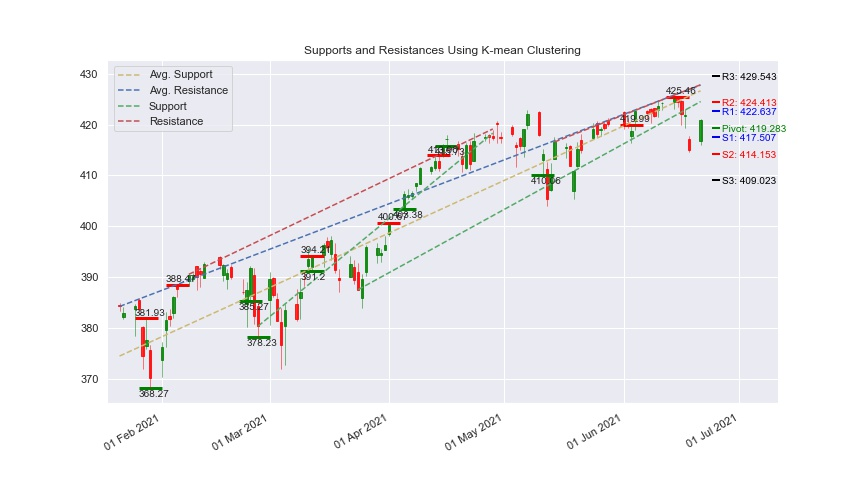

In [22]:
#image_to_data_url('test.jpg')

In [ ]:
function showImage() 
{
 var ss=SpreadsheetApp.getActiveSpreadsheet() 
 var formulaSheet = ss.getSheetByName("Sheet1");
 var formulaCell = formulaSheet.getRange("B5");
 formulaCell.setFormula('=IMAGE("http://finviz.com/fut_chart.ashx?t=ES&p&p=m5&s=m",4,100,200)')
}

In [ ]:
from google.oauth2 import service_account
import requests
import json
import google.auth.transport.requests

SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'service_account.json'

credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)

delegated_credentials = credentials.with_subject('[USER-EMAIL-TO-IMPERSONATE]')
delegated_credentials.refresh(google.auth.transport.requests.Request())
token = delegated_credentials.token

headers = {'content-type': 'application/json', 'Authorization': 'Bearer ' + token}
url = '[WEB-APP-URL]'
data = {"file": '[blob]'}
response = requests.post(url, data=json.dumps(data), headers=headers)